In [1]:
#优化 进行预剪枝的决策树
def getData(filename):
    f = open(filename,'r')
    datas = f.readlines()
    label = datas[0].split(',')
    del (label[6])
    # label[len(label)-1] = label[len(label)-1].replace('\n','')
    data_set = []
    for i in range(1,len(datas)):
        temp = datas[i].split(',')
        temp[len(temp) - 1] = temp[len(temp) - 1].replace('\n', '')
        data_set.append(temp)
    return label,data_set

label_set,data_set = getData('Experiment1/data/car_data.csv')

print(label_set)
#加载训练数据 80% 测试数据 20%
train_list = data_set[0:1382]  # 训练集 数据
test_list = data_set[1383:]  # 测试集 数据
print('训练集大小',len(train_list))
print('测试集大小',len(test_list))

label_count = {'buying':4,'maint':4,'doors':4,'persons':3,'lug_boot':3,'safety':3}

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
训练集大小 1382
测试集大小 345


In [10]:
def training(features, targets):
    # 计算各类别的样本个数
    label_count = {}
    for classify in targets:
        if classify not in label_count.keys():
            label_count[classify] = 0
        label_count[classify] += 1
    k = len(label_count.keys())  # 类别数
    # feature 的 m行  n列
    m = len(features)
    n = len(features[0])
    # 计算先验概率  每一类出现的概率
    lamb = 1  # 平滑处理的参数  拉普拉斯修正
    prior = dict()  # 存储先验概率

    for label, amount in label_count.items():
        prior[label] = (amount + lamb) / (m + k * lamb)  # 计算平滑处理后的先验概率 拉普拉斯修正


    conditional = dict()  # 存储条件概率
    for feature in range(n):  # 遍历每个特征
        conditional[feature] = {}
        values = []  # 存放 每一个特征有多少种取值
        for data in features:
            if data[feature] not in values:
                values.append(data[feature])
        for value in values:  # 遍历特征值的每一个取值
            conditional[feature][value] = {}  # 第i的特征的取值value
            for label, amount in label_count.items():  # 遍历每种类别
                # 截取该类别的数据集
                feature_label = []  # 存储类别为label的数据集
                for j in range(0, m):
                    if label == targets[j]:
                        feature_label.append(features[j])
                # 计算该类别下各特征值出现的次数
                c_label = {}  # 存放该类别下 每一个特征值出现的次数
                for data in feature_label:
                    if data[feature] not in c_label.keys():
                        c_label[data[feature]] = 0
                    c_label[data[feature]] += 1
                # 计算平滑处理后的条件概率  拉普拉斯修正
                conditional[feature][value][label] = (c_label.get(value, 0) + lamb) / \
                                                     (amount + len(values) * lamb)  # 计算平滑处理后的条件概率

    return prior, conditional

features = []  # 数据在每一纬度的特征   特征集m*n,m为样本数,n为特征数
target = []  # 数据的真实分类   标签集
for data in train_list:
    features.append(data[0:-1])
    target.append(data[-1])
prior, conditional = training(features, target)  # 计算 先验概率  条件概率
print("先验概率")
print(prior)
print("条件概率")
print(conditional)


先验概率
{'acc': 0.227994227994228, 'unacc': 0.6926406926406926, 'good': 0.04184704184704185, 'vgood': 0.03751803751803752}
条件概率
{0: {'high': {'acc': 0.27586206896551724, 'unacc': 0.2751817237798546, 'good': 0.01639344262295082, 'vgood': 0.01818181818181818}, 'low': {'acc': 0.22570532915360503, 'unacc': 0.2087227414330218, 'good': 0.639344262295082, 'vgood': 0.5636363636363636}, 'vhigh': {'acc': 0.19435736677115986, 'unacc': 0.30218068535825543, 'good': 0.01639344262295082, 'vgood': 0.01818181818181818}, 'med': {'acc': 0.30407523510971785, 'unacc': 0.21391484942886813, 'good': 0.32786885245901637, 'vgood': 0.4}}, 1: {'low': {'acc': 0.23510971786833856, 'unacc': 0.22533748701973, 'good': 0.6557377049180327, 'vgood': 0.41818181818181815}, 'vhigh': {'acc': 0.1786833855799373, 'unacc': 0.2949117341640706, 'good': 0.01639344262295082, 'vgood': 0.01818181818181818}, 'med': {'acc': 0.3103448275862069, 'unacc': 0.22741433021806853, 'good': 0.3114754098360656, 'vgood': 0.38181818181818183}, 'high':

In [4]:
def predict(test, prior, conditional):
    """预测单个样本"""
    best_poster, best_label = -np.inf, -1
    for label in prior:
        # 初始化后验概率为先验概率,同时把连乘换成取对数相加，防止下溢（即太多小于1的数相乘，结果会变成0）
        poster = np.log(prior[label])
        for i in range(0, len(test)-1):
            # 第i个特征（第i列） 取值为test[i]  类别为label 的条件概率   由于取了对数 所以加变成了乘
            poster += np.log(conditional[i][test[i]][label])
        if poster > best_poster:  # 获取后验概率最大的类别
            best_poster = poster
            best_label = label
    return best_label


pos_count = 0  # 正确分类数量
neg_count = 0  # 错误分类数量
import numpy as np
classify_result_list = []  # 存储分类结果
for test in test_list:
    classify_result = predict(test, prior, conditional)
    classify_result_list.append(classify_result)

for i in range(0, len(classify_result_list)):
    if classify_result_list[i] == test_list[i][6]:
        pos_count += 1
    else:
        neg_count += 1
print('测试集总数', len(test_list))
print('正确分类数', pos_count)
print('错误分类数', neg_count)
print('分类的准确率为', pos_count / len(test_list))

测试集总数 345
正确分类数 294
错误分类数 51
分类的准确率为 0.8521739130434782


对于结果为unacc  即数据集中classify 为0的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.7797029702970297
精度(查准率) ———— 0.7555555555555555
召回率(查全率)———— 0.7797029702970297
f1值 ———— 0.8424778761061947


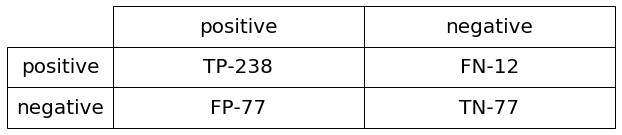

In [6]:
#对于结果为unacc  classify 为0  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为unacc  即数据集中classify 为0的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为0 且真实为0的数据   将一个正例正确判断为正例
#fp 为预测结果为0 且真实为1，2，3的数据    将一个反例错误判断为正例
#fn 为预测结果为1，2，3 且真实为0的数据     将一个正例错误判断为反例
#tn 为预测结果为1，2，3 且真实为1，2，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == 'unacc' and  classify_result_list[i] == 'unacc':
        tp += 1
    if test_list[i][6] == 'unacc' and  classify_result_list[i] != 'unacc':
        fn += 1
    if test_list[i][6] != 'unacc' and  classify_result_list[i] != 'unacc':
        fp += 1
    if test_list[i][6] != 'unacc' and  classify_result_list[i] != 'unacc':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值 
f1 = (2*precision*recall) / (precision+recall)
print('f1值 ————',f1)


            
            
       


对于结果为acc  即数据集中classify 为1的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.5277280858676208
精度(查准率) ———— 0.1694915254237288
召回率(查全率)———— 0.5277280858676208
f1值 ———— 0.2747252747252747


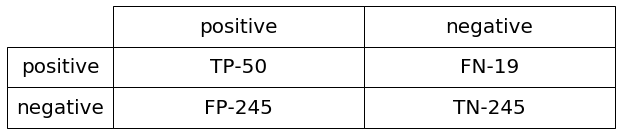

In [7]:
#对于结果为acc  classify 为1  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为acc  即数据集中classify 为1的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为1 且真实为1的数据   将一个正例正确判断为正例
#fp 为预测结果为1 且真实为0，2，3的数据    将一个反例错误判断为正例
#fn 为预测结果为0，2，3 且真实为1的数据     将一个正例错误判断为反例
#tn 为预测结果为0，2，3 且真实为0，2，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == 'acc' and  classify_result_list[i] == 'acc':
        tp += 1
    if test_list[i][6] == 'acc' and  classify_result_list[i] != 'acc':
        fn += 1
    if test_list[i][6] != 'acc' and  classify_result_list[i] != 'acc':
        fp += 1
    if test_list[i][6] != 'acc' and  classify_result_list[i] != 'acc':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值 
f1 = (2*precision*recall) / (precision+recall)
print('f1值 ————',f1)

对于结果为good  即数据集中classify 为2的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.49258160237388726
精度(查准率) ———— 0.0030120481927710845
召回率(查全率)———— 0.49258160237388726
f1值 ———— 0.005813953488372093


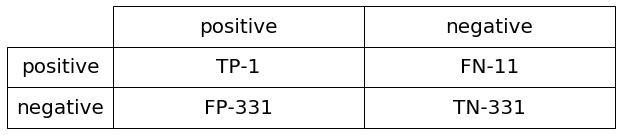

In [8]:
#对于结果为good  classify 为2  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为good  即数据集中classify 为2的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为2 且真实为2的数据   将一个正例正确判断为正例
#fp 为预测结果为2 且真实为0，1，3的数据    将一个反例错误判断为正例
#fn 为预测结果为0，1，3 且真实为2的数据     将一个正例错误判断为反例
#tn 为预测结果为0，1，3 且真实为0，1，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == 'good' and  classify_result_list[i] == 'good':
        tp += 1
    if test_list[i][6] == 'good' and  classify_result_list[i] != 'good':
        fn += 1
    if test_list[i][6] != 'good' and  classify_result_list[i] != 'good':
        fp += 1
    if test_list[i][6] != 'good' and  classify_result_list[i] != 'good':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值 
if 2*precision*recall == 0:
    print('f1值 ————',0.0)
else:
    f1 = (2*precision*recall) / (precision+recall)
    print('f1值 ————',f1)

对于结果为vgood  即数据集中classify 为3的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.4970414201183432
精度(查准率) ———— 0.01488095238095238
召回率(查全率)———— 0.4970414201183432
f1值 ———— 0.02857142857142857


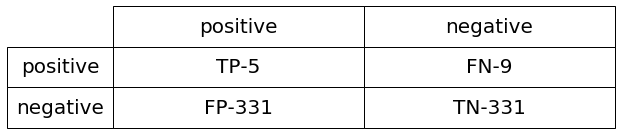

In [9]:
#对于结果为vgood  classify 为3  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为vgood  即数据集中classify 为3的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为2 且真实为2的数据   将一个正例正确判断为正例
#fp 为预测结果为2 且真实为0，1，3的数据    将一个反例错误判断为正例
#fn 为预测结果为0，1，3 且真实为2的数据     将一个正例错误判断为反例
#tn 为预测结果为0，1，3 且真实为0，1，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == 'vgood' and  classify_result_list[i] == 'vgood':
        tp += 1
    if test_list[i][6] == 'vgood' and  classify_result_list[i] != 'vgood':
        fn += 1
    if test_list[i][6] != 'vgood' and  classify_result_list[i] != 'vgood':
        fp += 1
    if test_list[i][6] != 'vgood' and  classify_result_list[i] != 'vgood':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值
if 2*precision*recall == 0:
    print('f1值 ————',0.0)
else:
    f1 = (2*precision*recall) / (precision+recall)
    print('f1值 ————',f1)

In [14]:
temp_test_list = test_list[0:2]
def predict(test, prior, conditional):
    """预测单个样本"""
    best_poster, best_label = -np.inf, -1
    for label in prior:
        print('类别',label,'的先验概率为',prior[label])
        # 初始化后验概率为先验概率,同时把连乘换成取对数相加，防止下溢（即太多小于1的数相乘，结果会变成0）
        poster = np.log(prior[label])
        for i in range(0, len(test)-1):
            # 第i个特征（第i列） 取值为test[i]  类别为label 的条件概率   由于取了对数 所以加变成了乘
            print('当特征',label_set[i],'取值为',test[i],'时，条件概率为',conditional[i][test[i]][label])
            poster += np.log(conditional[i][test[i]][label])
        print('类别',label,'的后验概率为为',poster)
        print()
        if poster > best_poster:  # 获取后验概率最大的类别
            best_poster = poster
            best_label = label
    return best_label



for test in temp_test_list:
    print('数据标签为',label_set)
    print('测试数据为',test )
    classify_result = predict(test, prior, conditional)
    print('比较之后，分类为','=>',classify_result)
    print()
    print()


数据标签为 ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
测试数据为 ['low', 'low', '5more', '2', 'small', 'low', 'unacc']
类别 acc 的先验概率为 0.227994227994228
当特征 buying 取值为 low 时，条件概率为 0.22570532915360503
当特征 maint 取值为 low 时，条件概率为 0.23510971786833856
当特征 doors 取值为 5more 时，条件概率为 0.2852664576802508
当特征 persons 取值为 2 时，条件概率为 0.0031446540880503146
当特征 lug_boot 取值为 small 时，条件概率为 0.2672955974842767
当特征 safety 取值为 low 时，条件概率为 0.0031446540880503146
类别 acc 的后验概率为为 -18.51249742729847

类别 unacc 的先验概率为 0.6926406926406926
当特征 buying 取值为 low 时，条件概率为 0.2087227414330218
当特征 maint 取值为 low 时，条件概率为 0.22533748701973
当特征 doors 取值为 5more 时，条件概率为 0.2336448598130841
当特征 persons 取值为 2 时，条件概率为 0.4625779625779626
当特征 lug_boot 取值为 small 时，条件概率为 0.37733887733887733
当特征 safety 取值为 low 时，条件概率为 0.48336798336798337
类别 unacc 的后验概率为为 -7.3506302968570605

类别 good 的先验概率为 0.04184704184704185
当特征 buying 取值为 low 时，条件概率为 0.639344262295082
当特征 maint 取值为 low 时，条件概率为 0.6557377049180327
当特征 doors 取值为 5more 时，条件概率为 0.29508196721